In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import gmtime, strftime
from scipy.signal import butter, lfilter


LOG_DIR = "logs/"
PLOT_DIR = "plots/"


class QRSDetectorOffline(object):
    
    def __init__(self, ecg_data_path, verbose=True, log_data=False, plot_data=False, show_plot=False):
        """
        QRSDetectorOffline class initialisation method.
        :param string ecg_data_path: path to the ECG dataset
        :param bool verbose: flag for printing the results
        :param bool log_data: flag for logging the results
        :param bool plot_data: flag for plotting the results to a file
        :param bool show_plot: flag for showing generated results plot - will not show anything if plot is not generated
        """
        # Configuration parameters.
        self.ecg_data_path = ecg_data_path

        self.signal_frequency = 1000  # Set ECG device frequency in samples per second here.

        self.filter_lowcut = 5.0
        self.filter_highcut = 15.0
        self.filter_order = 1

        self.integration_window = 15  # Change proportionally when adjusting frequency (in samples).

        self.findpeaks_limit = 0.35
        self.findpeaks_spacing = 50  # Change proportionally when adjusting frequency (in samples).

        self.refractory_period = 120  # Change proportionally when adjusting frequency (in samples).
        self.qrs_peak_filtering_factor = 0.125
        self.noise_peak_filtering_factor = 0.125
        self.qrs_noise_diff_weight = 0.25

        # Loaded ECG data.
        self.ecg_data_raw = None

        # Measured and calculated values.
        self.filtered_ecg_measurements = None
        self.differentiated_ecg_measurements = None
        self.squared_ecg_measurements = None
        self.integrated_ecg_measurements = None
        self.detected_peaks_indices = None
        self.detected_peaks_values = None

        self.qrs_peak_value = 0.0
        self.noise_peak_value = 0.0
        self.threshold_value = 0.0

        # Detection results.
        self.qrs_peaks_indices = np.array([], dtype=int)
        self.noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        self.ecg_data_detected = None

        # Run whole detector flow.
        self.load_ecg_data()
        self.detect_peaks()
        self.detect_qrs()

        if verbose:
            self.print_detection_data()

        if log_data:
            self.log_path = "{:s}QRS_offline_detector_log_{:s}.csv".format(LOG_DIR,
                                                                           strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.log_detection_data()

        if plot_data:
            self.plot_path = "{:s}QRS_offline_detector_plot_{:s}.png".format(PLOT_DIR,
                                                                             strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.plot_detection_data(show_plot=show_plot)

    """Loading ECG measurements data methods."""

    def load_ecg_data(self):
        """
        Method loading ECG data set from a file.
        """
        self.ecg_data_raw = np.loadtxt(self.ecg_data_path, skiprows=1, delimiter=',')

    """ECG measurements data processing methods."""

    def detect_peaks(self):
        """
        Method responsible for extracting peaks from loaded ECG measurements data through measurements processing.
        """
        # Extract measurements from loaded ECG data.
        ecg_measurements = self.ecg_data_raw[:, 1]

        # Measurements filtering - 0-15 Hz band pass filter.
        self.filtered_ecg_measurements = self.bandpass_filter(ecg_measurements, lowcut=self.filter_lowcut,
                                                              highcut=self.filter_highcut, signal_freq=self.signal_frequency,
                                                              filter_order=self.filter_order)
        self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
        self.differentiated_ecg_measurements = np.ediff1d(self.filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
        self.squared_ecg_measurements = self.differentiated_ecg_measurements ** 2

        # Moving-window integration.
        self.integrated_ecg_measurements = np.convolve(self.squared_ecg_measurements, np.ones(self.integration_window))

        # Fiducial mark - peak detection on integrated measurements.
        self.detected_peaks_indices = self.findpeaks(data=self.integrated_ecg_measurements,
                                                     limit=self.findpeaks_limit,
                                                     spacing=self.findpeaks_spacing)

        self.detected_peaks_values = self.integrated_ecg_measurements[self.detected_peaks_indices]

    """QRS detection methods."""

    def detect_qrs(self):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        """
        for detected_peak_index, detected_peaks_value in zip(self.detected_peaks_indices, self.detected_peaks_values):

            try:
                last_qrs_index = self.qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > self.refractory_period or not self.qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > self.threshold_value:
                    self.qrs_peaks_indices = np.append(self.qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    self.qrs_peak_value = self.qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - self.qrs_peak_filtering_factor) * self.qrs_peak_value
                else:
                    self.noise_peaks_indices = np.append(self.noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    self.noise_peak_value = self.noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - self.noise_peak_filtering_factor) * self.noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                self.threshold_value = self.noise_peak_value + \
                                       self.qrs_noise_diff_weight * (self.qrs_peak_value - self.noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(self.ecg_data_raw[:, 1]), 1])
        measurement_qrs_detection_flag[self.qrs_peaks_indices] = 1
        self.ecg_data_detected = np.append(self.ecg_data_raw, measurement_qrs_detection_flag, 1)

    """Results reporting methods."""

    def print_detection_data(self):
        """
        Method responsible for printing the results.
        """
        print("qrs peaks indices")
        print(self.qrs_peaks_indices)
        print("noise peaks indices")
        print(self.noise_peaks_indices)

    def log_detection_data(self):
        """
        Method responsible for logging measured ECG and detection results to a file.
        """
        with open(self.log_path, "wb") as fin:
            fin.write(b"timestamp,ecg_measurement,qrs_detected\n")
            np.savetxt(fin, self.ecg_data_detected, delimiter=",")

    def plot_detection_data(self, show_plot=False):
        """
        Method responsible for plotting detection results.
        :param bool show_plot: flag for plotting the results and showing plot
        """
        def plot_data(axis, data, title='', fontsize=10):
            axis.set_title(title, fontsize=fontsize)
            axis.grid(which='both', axis='both', linestyle='--')
            axis.plot(data, color="salmon", zorder=1)

        def plot_points(axis, values, indices):
            axis.scatter(x=indices, y=values[indices], c="black", s=50, zorder=2)

        plt.close('all')
        fig, axarr = plt.subplots(5, sharex=True, figsize=(15, 18))

        plot_data(axis=axarr[0], data=self.ecg_data_raw[:, 1], title='Raw ECG measurements')
        plot_data(axis=axarr[1], data=self.filtered_ecg_measurements, title='Filtered ECG measurements')
        plot_data(axis=axarr[2], data=self.differentiated_ecg_measurements, title='Differentiated ECG measurements')
        plot_data(axis=axarr[3], data=self.squared_ecg_measurements, title='Squared ECG measurements')
        #plot_data(axis=axarr[4], data=self.integrated_ecg_measurements, title='Integrated ECG measurements with QRS peaks marked (black)')
        #plot_points(axis=axarr[4], values=self.integrated_ecg_measurements, indices=self.qrs_peaks_indices)
        #plot_data(axis=axarr[5], data=self.ecg_data_detected[:, 1], title='Raw ECG measurements with QRS peaks marked (black)')
        #plot_points(axis=axarr[5], values=self.ecg_data_detected[:, 1], indices=self.qrs_peaks_indices)

        plt.tight_layout()
        fig.savefig(self.plot_path)

        if show_plot:
            plt.show()

        plt.close()

    """Tools methods."""

    def bandpass_filter(self, data, lowcut, highcut, signal_freq, filter_order):

        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        if low==0.0 :
            low+=0.00000001
        print(low,high)
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
       
        return y

    def findpeaks(self, data, spacing=1, limit=None):

        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind





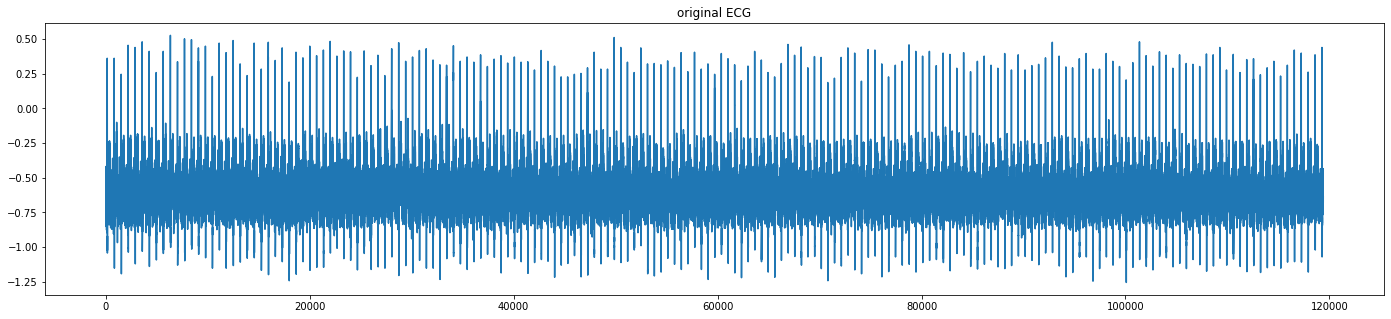

In [2]:
ch1 = []
ch2 = []
count = []
filename = 'Test'
dataName = 'Q-data/Q010/Q010-1.txt'
fp = open(dataName, "r")
line = fp.readline()
 
## 用 while 逐行讀取檔案內容，直至檔案結尾
line_count = 0
while line:    
    #a = input("input:")
    if( line_count >= 5):
        #print (line)
        x =line.split()
        ch1.append(float(x[1]))
        ch2.append(float(x[2]))
        count.append(float(x[0]))
        #print(x)
    line = fp.readline()
    line_count+=1
    
plt.figure(figsize=(24,5))
plt.plot(count,ch1)
plt.title("original ECG")
plt.show()


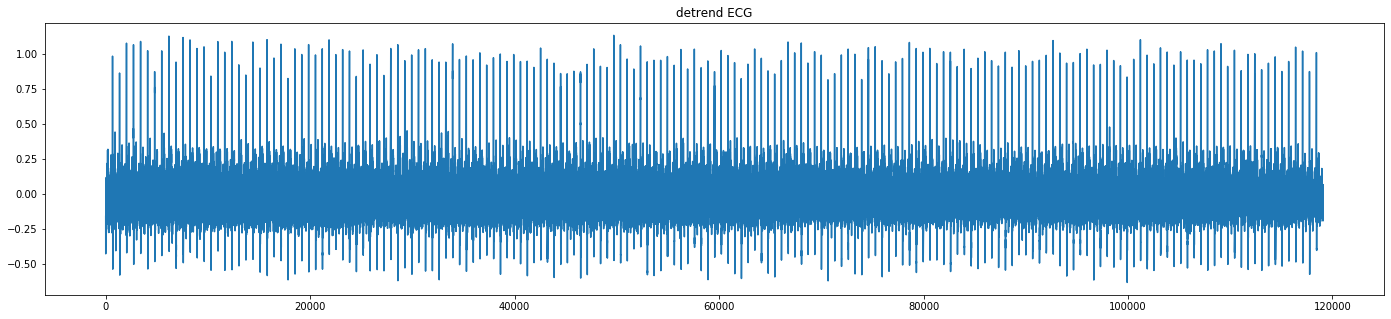

In [3]:
import scipy.signal
degree = 150
def detrend(data,degree):
    detrended=[None]*degree
    for i in range(degree,len(data)-degree):
        chunk=data[i-degree:i+degree]
        chunk=sum(chunk)/len(chunk)
        detrended.append(data[i]-chunk)
    return detrended+[None]*degree
ch8=detrend(ch1,degree = degree)
plt.figure(figsize=(24,5))
plt.plot(ch8[degree:-degree] )
plt.title("detrend ECG")
plt.show()

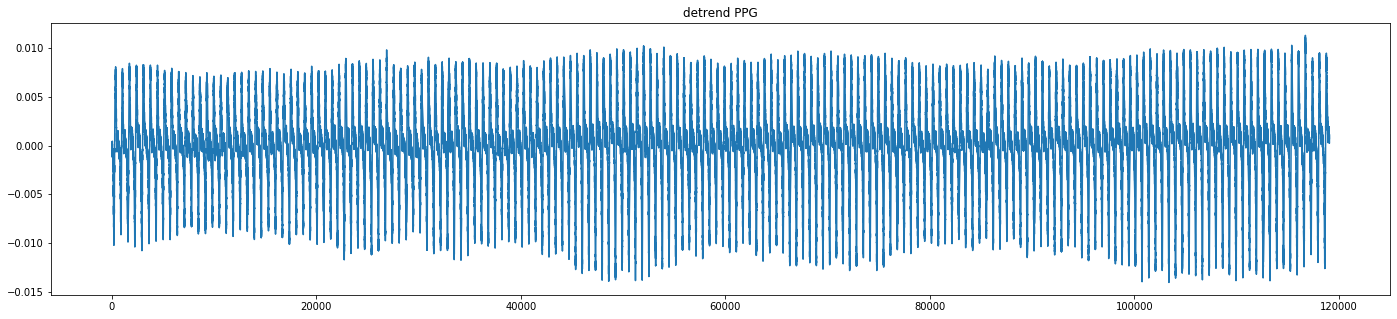

In [4]:
#Detrending 去頭尾150
ffty=detrend(ch2,degree = degree)
plt.figure(figsize=(24,5))
plt.plot(ffty[degree:-degree] )
plt.title("detrend PPG")
plt.show()

In [5]:
import pandas as pd
dfObj = pd.DataFrame(list(zip(count[degree:-degree],ch8[degree:-degree])), columns = ['count','ch1']) 
dfObj.to_csv(''+filename+'_ECG'+'.csv', index=False)
#dfObj


0.01 0.03
qrs peaks indices
[]
noise peaks indices
[]


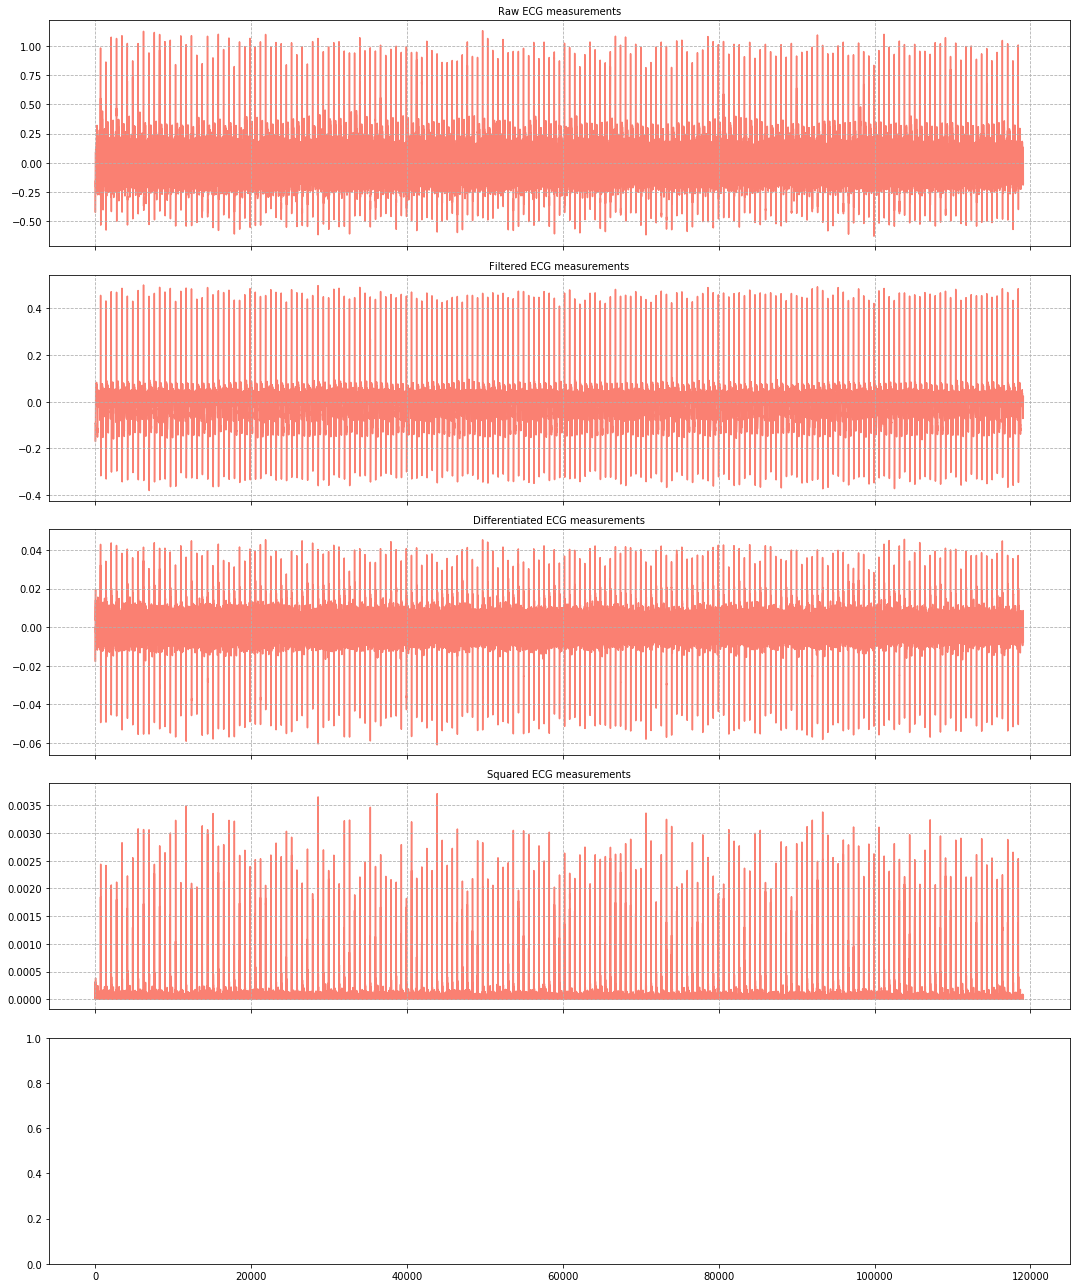

In [6]:
qrs_detector2 = QRSDetectorOffline(ecg_data_path=''+filename+'_ECG'+'.csv', verbose=True,
                                  log_data=False, plot_data=True, show_plot=True)

180


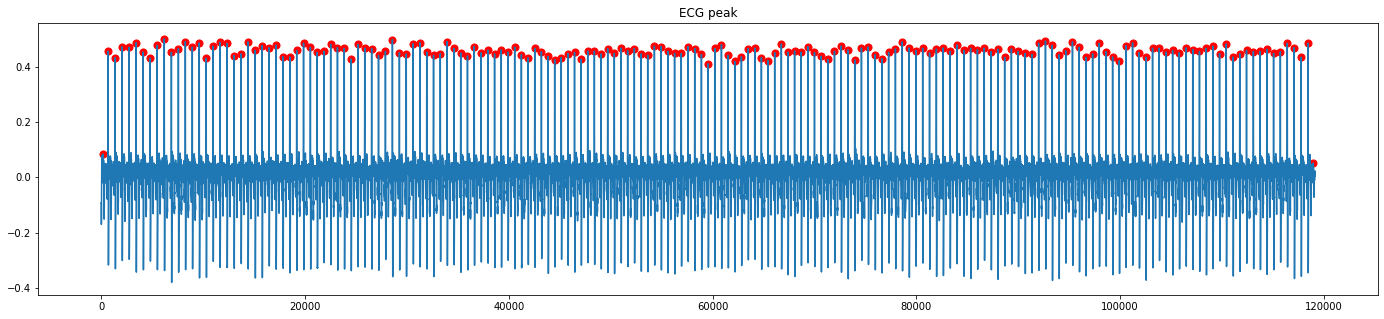

In [7]:
import time
import numpy as np
import plotly.graph_objs as go
import pandas as pd
import peakutils
from time import strftime
from scipy.interpolate import interp1d
#ECG
#count.sort()
time_series = qrs_detector2.filtered_ecg_measurements
cb = np.array(time_series)
indices_ECG = peakutils.indexes(cb, thres=0.2, min_dist=500)
print(len(indices_ECG))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices_ECG,
    y=[time_series[j] for j in indices_ECG],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)


data = [trace,trace2]


plt.figure(figsize=(24, 5))
plt.plot(trace['x'], trace['y'])
plt.scatter(trace2['x'], trace2['y'], s=50, c='r')
plt.title("ECG peak")
plt.show()

In [8]:
#normalize
def interp(_y):
    _x = np.linspace(0, len(_y), len(_y))
    _f = interp1d(_x, _y, kind="slinear")
    _new_x = np.linspace(0, len(_y), 2000)
    return _f(_new_x)
#interpolate
ecg_slice = []
_init = trace2['x'][2]
for i in trace2['x'][3:-2] :
    ecg_slice.append(trace['y'][_init:i]/np.max(trace['y'][_init:i]))
    _init = i

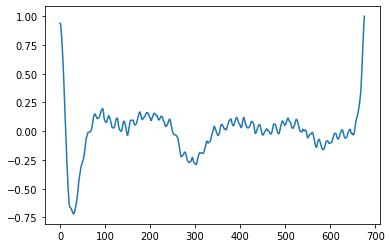

In [9]:
plt.plot(ecg_slice[0])

In [13]:
with open(dataName[-10:], 'w') as f:
    for item in ecg_slice[:-3]:
        for i in item :
            f.write(str(i) + " ")
        f.write("\n")

In [26]:
with open(dataName[-10:],'r') as fp:
     all_lines = fp.readlines()

In [28]:
txtData = []
for i in all_lines :
    _i = []
    for j in i.split():
        _i.append(float(j))
    txtData.append(_i)    
np.array(txtData).shape

(174, 10000)

In [173]:
_pp = []
for i in ecg_slice :
    _pp.append(len(i))
print(np.mean(_pp))
print(np.min(_pp))
print(np.max(_pp))

664.3898305084746
518
700


179
179


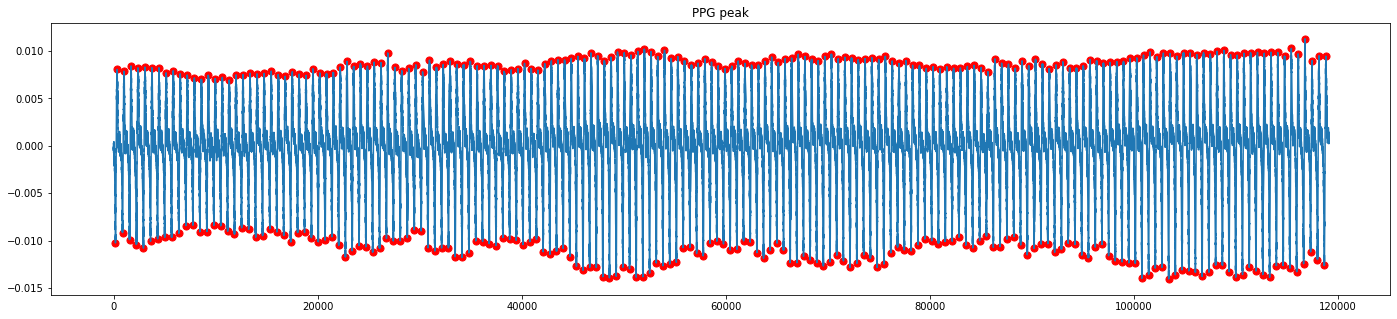

In [40]:
#PPG
#count.sort()
time_series = ffty[degree:-degree] 
cb = np.array(time_series)
indices = peakutils.indexes(cb, thres=0.4, min_dist=500)
print(len(indices))
trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)
traceInverse = []
for i in time_series :
    traceInverse.append(i*-1)
cb = np.array(traceInverse)
indices = peakutils.indexes(cb, thres=0.15, min_dist=600)
print(len(indices))
trace3 = go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace,trace2]
plt.figure(figsize=(24, 5))
plt.plot(trace['x'], trace['y'])
plt.scatter(np.append(trace2['x'], trace3['x']),np.append(trace2['y'], trace3['y']), s=50, c='r')
plt.title("PPG peak")
plt.show()


169 -523
144 -543
137 -529
158 -539
137 -556
132 -559
137 -560
136 -545
153 -546
130 -562
137 -561
137 -533
151 -543
131 -556
137 -525
161 -523
157 -513
142 -562
133 -551
149 -543
129 -543
155 -554
146 -543
137 -541
147 -533
161 -520
144 -534
138 -532
149 -531
138 -530
141 -529
130 -528
153 -508
146 -509
151 -533
129 -524
164 -502
154 -541
130 -537
126 -543
148 -538
147 -538
140 -542
157 -519
143 -534
138 -528
160 -502
161 -509
160 -502
160 -503
169 -503
141 -538
141 -527
137 -509
170 -504
153 -512
126 -538
154 -497
158 -508
143 -508
137 -527
146 -510
151 -504
147 -504
143 -519
127 -514
142 -508
144 -499
147 -511
124 -518
139 -510
145 -498
139 -529
125 -527
130 -516
148 -503
163 -496
138 -520
146 -511
131 -521
152 -506
134 -521
148 -518
130 -537
143 -510
149 -502
150 -525
134 -520
137 -516
145 -514
153 -501
129 -525
127 -526
131 -516
162 -494
134 -523
141 -525
128 -507
157 -500
140 -513
136 -514
140 -512
142 -506
131 -517
144 -510
130 -522
157 -504
137 -502
155 -510
150 -528
143 -506
1

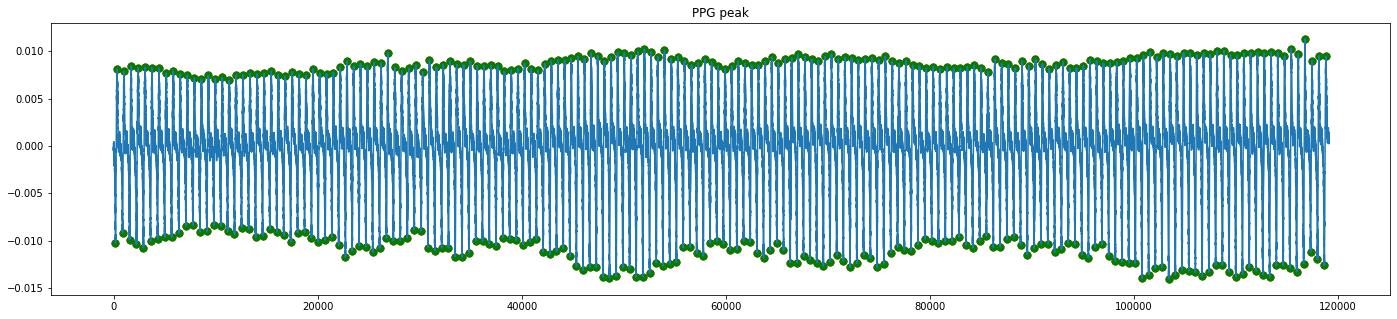

In [42]:
ignore2 = 0
ignore3 = 0
ggg = 0

cleanX = []
cleanY = []
updown = []
if trace3['x'][0] > trace2['x'][0]:
    trace2['x'].pop(0)
    trace2['y'].pop(0)
for i in range(500):
    error2 = 0
    if i+ignore3+1 >= len(trace3['x']):
        break
    if i+ignore2 >= len(trace2['x']):
        break
    ggg = 0
    print(trace2['x'][i+ignore2+ggg]-trace3['x'][i+ignore3],
          trace2['x'][i+ignore2+ggg]-trace3['x'][i+ignore3+1])
    if trace2['x'][i+ignore2]-trace3['x'][i+ignore3] < 0:
        ignore2 += 1
        error2 = 1
        print('2error')

    if trace2['x'][i+ignore2+ggg]-trace3['x'][i+1+ignore3] > 0 | error2 == 1:
        ignore3 += 1
        #ggg = 1
        print('23error')

    if trace2['x'][i+ignore2+ggg]-trace3['x'][i+1+ignore3] > 0:
        ignore3 += 1
        ggg = 1
        print('3error')

    cleanX.append(trace2['x'][i+ignore2+ggg])
    cleanY.append(trace2['y'][i+ignore2+ggg])
    cleanX.append(trace3['x'][i+ignore3+ggg])
    cleanY.append(trace3['y'][i+ignore3+ggg])
    updown.append(trace2['y'][i+ignore2+ggg]-trace3['y'][i+ignore3+ggg])
    # print(i+ignore2+ggg,i+ignore3+ggg)
    # print(trace2['x'][i+ignore2+ggg],trace2['y'][i+ignore2+ggg])
    # print(trace3['x'][i+ignore3],trace3['y'][i+ignore3])
    # print(trace2['x'][i+ignore2+ggg]-trace3['x'][i+ignore3],trace2['x'][i+ignore2+ggg]-trace3['x'][i+ignore3+1])
    # print("y:",trace2['y'][i+ignore2+ggg]-trace3['y'][i+ignore3])
if(trace2['x'][-1] > trace3['x'][-1]):
    print(trace2['x'][-1], trace3['x'][-1])
    cleanX.append(trace2['x'][-1])
    cleanY.append(trace2['y'][-1])
    cleanX.append(trace3['x'][-1])
    cleanY.append(trace3['y'][-1])
    updown.append(trace2['y'][-1]-trace3['y'][-1])
plt.figure(figsize=(24, 5))
plt.plot(trace['x'], trace['y'])
plt.scatter(np.append(trace2['x'], trace3['x']),
            np.append(trace2['y'], trace3['y']), s=50, c='r')
plt.scatter(cleanX, cleanY, s=50, c='g')
plt.title("PPG peak")
plt.show()


<Figure size 432x288 with 0 Axes>

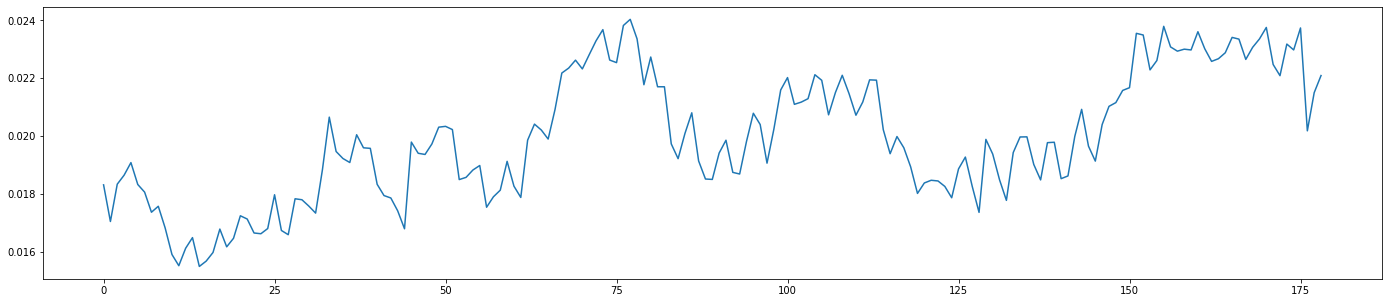

In [49]:
subList = []
for i in np.linspace(0,int(len(cleanY)-2),(len(cleanY)/2)) :
    subList.append(cleanY[int(i)]-cleanY[int(i+1)])
plt.clf()    
plt.figure(figsize=(24, 5))
plt.plot(subList)   

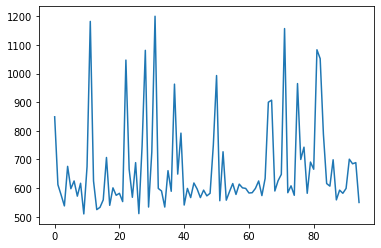

count      95.000000
mean      670.915789
std       160.085992
min       510.000000
25%       577.000000
50%       607.000000
75%       695.000000
max      1200.000000
Name: ECG, dtype: float64
RRIV = 1.0284450162386056


In [21]:
#ECG

a = []
for i in range(len(indices_ECG)-1) :
    a .append(indices_ECG[i+1]-indices_ECG[i])

pdsignal= pd.DataFrame(a, columns = ['ECG']) 

plt.plot(pdsignal['ECG'])
plt.show()
print(pdsignal['ECG'].describe())
print("RRIV = "+str((pdsignal['ECG'].max()-pdsignal['ECG'].min())/pdsignal['ECG'].mean()))
count = 0
with open('ECG.txt', 'w') as f:
    for item in pdsignal['ECG']:
        f.write("%s\n" % str(item/1000))
        count+=item/1000

In [22]:
pdsignal['ECG'].describe()

count      95.000000
mean      670.915789
std       160.085992
min       510.000000
25%       577.000000
50%       607.000000
75%       695.000000
max      1200.000000
Name: ECG, dtype: float64

In [23]:
for i , num in enumerate(pdsignal['ECG'].describe()):
    print(i,num)

0 95.0
1 670.9157894736842
2 160.0859917295711
3 510.0
4 577.0
5 607.0
6 695.0
7 1200.0


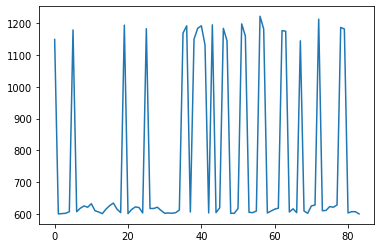

count      84.000000
mean      766.857143
std       253.603720
min       601.000000
25%       605.750000
50%       617.500000
75%      1144.000000
max      1221.000000
Name: PPG, dtype: float64
RRIV = 0.8084947839046199


In [24]:
#PPG
a = []
for i in range(len(indices)-1) :
  a .append(indices[i+1]-indices[i])
  
pdsignal= pd.DataFrame(a, columns = ['PPG'])

plt.plot(pdsignal['PPG'])
plt.show()
print(pdsignal['PPG'].describe())
print("RRIV = "+str((pdsignal['PPG'].max()-pdsignal['PPG'].min())/pdsignal['PPG'].mean()))
with open('PPG.txt', 'w') as f:
    for item in pdsignal['PPG']:
        f.write("%s\n" % str(item/1000))

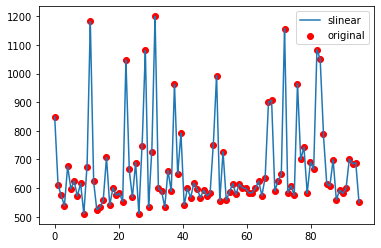

95
原始長度 :  95
插值後長度 :  95000
[0.00000000e+00 1.05263158e-02 2.10526316e-02 ... 4.99968421e+02
 4.99978947e+02 4.99989474e+02]
面積 167.49279970861988
[15.55581562 15.84301189 10.09261212 19.38086805 12.47333276 22.04970569
 13.31344546 17.3285204  13.60919288 12.97155028 14.87474456]


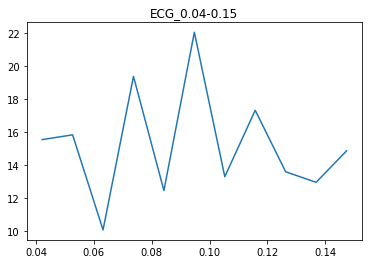

[0.00000000e+00 1.05263158e-02 2.10526316e-02 ... 4.99968421e+02
 4.99978947e+02 4.99989474e+02]
面積 280.0390643222635
[14.22845112 12.25841602 29.66129385  4.98992631 27.53193135  7.46461582
 12.19409493 14.56269185  6.17138415 19.99552214 10.49742038  8.13708171
 11.7959083  13.77974739  8.94347793 11.16781881 13.14668581 13.20819986
 11.31702279 14.18008662  8.65054857  4.84624846  1.31049017]


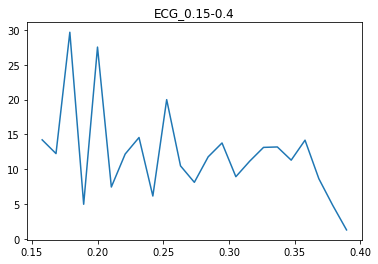

LH :  0.5981051254901796


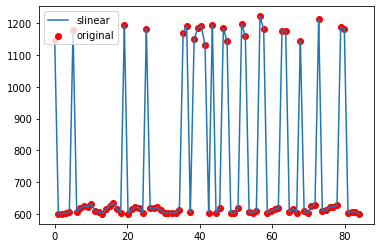

84
原始長度 :  84
插值後長度 :  84000
[0.00000000e+00 1.19047619e-02 2.38095238e-02 ... 4.99964286e+02
 4.99976190e+02 4.99988095e+02]
面積 183.87968035026233
[34.11873481 23.01178843 24.88274891 14.34333542 20.32780508 11.02202266
 18.92008437 29.7425509   7.51060977]


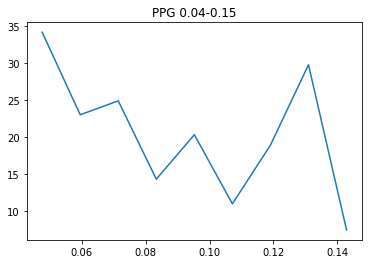

[0.00000000e+00 1.19047619e-02 2.38095238e-02 ... 4.99964286e+02
 4.99976190e+02 4.99988095e+02]
面積 412.0502793919077
[17.5880467   3.68770097 53.948415   65.39438377 15.72462482 21.22395946
 15.10347656 21.59155451 34.56679525  7.07034565 10.91291347 19.93905631
 20.24532403 15.63043747 13.95476426 12.77672291  0.48792621 11.64149537
 29.25817175 18.18203164  3.12213329]


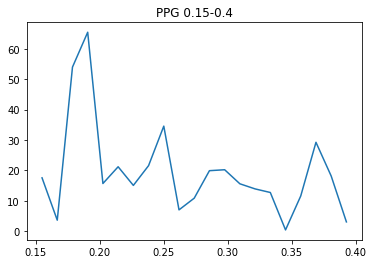

LH :  0.44625544392695676


In [25]:
def PPGgetLH(Y, frq1):
    return getPassbandPPG(0.04, 0.15, Y, frq1)/getPassbandPPG(0.15, 0.4, Y, frq1)
def ECGgetLH(Y, frq1):
    return getPassbandECG(0.04, 0.15, Y, frq1)/getPassbandECG(0.15, 0.4, Y, frq1)

def getPassbandPPG(lowPass, highPass, data,frq1):
    Y1 = data
    selectedLow = [x for x in frq1 if (x < lowPass)]
    selectedHigh = [x for x in frq1 if (x < highPass)]
    sum = 0
    print(frq1)
    for i in abs(Y[len(selectedLow):len(selectedHigh)]):
        sum += abs(i)
    print("面積", sum)
    print(abs(Y[len(selectedLow):len(selectedHigh)]))
    plt.plot(selectedHigh[len(selectedLow):], abs(
        Y1[len(selectedLow):len(selectedHigh)]))
    plt.title("PPG "+str(lowPass)+"-"+str(highPass))
    #plt.savefig(saveDir+"PPG_"+str(lowPass)+"-"+str(highPass)+".png")
    #plt.savefig('main/static/imgs/'+"PPG_"+str(lowPass)+"-"+str(highPass)+".png")
    plt.show()
    return sum

def getPassbandECG(lowPass, highPass, data, frq1):
    Y1 = data
    selectedLow = [x for x in frq1 if (x < lowPass)]
    selectedHigh = [x for x in frq1 if (x < highPass)]
    sum = 0
    print(frq1)
    for i in abs(Y[len(selectedLow):len(selectedHigh)]):
        sum += abs(i)
    print("面積", sum)
    print(abs(Y[len(selectedLow):len(selectedHigh)]))
    plt.plot(selectedHigh[len(selectedLow):], abs(
        Y1[len(selectedLow):len(selectedHigh)]))
    plt.title("ECG_"+str(lowPass)+"-"+str(highPass))
   # plt.savefig(saveDir+"ECG "+str(lowPass)+"-"+str(highPass)+".png")
    #plt.savefig('main/static/imgs/'+"ECG_"+str(lowPass)+"-"+str(highPass)+".png")
    plt.show()
    return sum


import matplotlib.pyplot as plt
a = []
for i in range(len(indices_ECG)-1):
    a.append(indices_ECG[i+1]-indices_ECG[i])

pdsignal = pd.DataFrame(a, columns=['ECG'])
# 原始数据
x = np.linspace(0, len(pdsignal['ECG']), len(pdsignal['ECG']))
y = pdsignal['ECG']

# 插值数据
new_x = np.linspace(0, len(y), len(y)*1000)
f = interp1d(x, y, kind="slinear")
new_y = f(new_x)
plt.scatter(x, y, label="original", color="r")
kind = "slinear"
plt.plot(new_x, new_y, label=kind)
plt.legend()
plt.show()
plt.clf()
print(len(y))

Fs = 1000             # sampling rate采样率
Ts = 1.0/Fs               # sampling interval 采样区间
t = np.linspace(0, len(new_y), len(new_y))      # time vector,这里Ts也是步长

# ff = 1000;                 # frequency of the signal
y = new_y

n = len(y)                  # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T                   # two sides frequency range
frq1 = frq[range(int(n/2))]  # one side frequency range

PPG_YY = np.fft.fft(y)          # 未归一化
Y = np.fft.fft(y)/n         # fft computing and normalization 归一化
Y1 = Y[range(int(n/2))]

print("原始長度 : ", len(pdsignal['ECG']))
print("插值後長度 : ", len(new_y))
print("LH : ", ECGgetLH(Y,frq1))
a = []
for i in range(len(indices)-1):
    a.append(indices[i+1]-indices[i])

pdsignal = pd.DataFrame(a, columns=['PPG'])
x = np.linspace(0, len(pdsignal['PPG']), len(pdsignal['PPG']))
y = pdsignal['PPG']

# 插值数据
new_x = np.linspace(0, len(y), len(y)*1000)
f = interp1d(x, y, kind="slinear")
new_y = f(new_x)
plt.scatter(x, y, label="original", color="r")
kind = "slinear"
plt.plot(new_x, new_y, label=kind)
plt.legend()
plt.show()
plt.clf()
print(len(y))

Fs = 1000             # sampling rate采样率
Ts = 1.0/Fs               # sampling interval 采样区间
t = np.linspace(0, len(new_y), len(new_y))      # time vector,这里Ts也是步长

# ff = 1000;                 # frequency of the signal
y = new_y

n = len(y)                  # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T                   # two sides frequency range
frq1 = frq[range(int(n/2))]  # one side frequency range

PPG_YY = np.fft.fft(y)          # 未归一化
Y = np.fft.fft(y)/n         # fft computing and normalization 归一化
Y1 = Y[range(int(n/2))]

print("原始長度 : ", len(pdsignal['PPG']))
print("插值後長度 : ", len(new_y))
print("LH : ", PPGgetLH(Y,frq1))

In [26]:
np.linspace(0,len(y)+1,len(y))


array([0.00000000e+00, 1.00002381e+00, 2.00004762e+00, ...,
       8.39990000e+04, 8.40000000e+04, 8.40010000e+04])